# Visualize train/test infrasound data (Cardinal array processing results)
---
#### 1. Load data created in notebook 1_Database_Construction
#### 2. Split data
#### 3. Plot train/test infrasound (Cardinal) processing results for each split
---
#### File paths represent those used in the study.
#### Users will have to be sure file paths match where they stored the data/spreadsheets.

In [3]:
%%time
import os, datetime
#-----------------------------------------------------------------------------------------------------------------------#
import numpy as np
import pandas as pd
import koreageonet_v1 as KGN
import matplotlib.pyplot as plt
#-----------------------------------------------------------------------------------------------------------------------#
from obspy import *
from pyproj import Geod
#-----------------------------------------------------------------------------------------------------------------------#
# ML Packages 
from tensorflow.keras import *
from sklearn.model_selection import StratifiedKFold

CPU times: user 86 µs, sys: 449 µs, total: 535 µs
Wall time: 544 µs


## Load data vectors and concatenate
---

In [2]:
%%time
# Earthquakes
data_eq = np.load('/Volumes/Extreme SSD/Korea_Events/Earthquakes/seismic_data_eq.npy')
metadata_eq = np.load('/Volumes/Extreme SSD/Korea_Events/Earthquakes/metadata_eq.npy')
stn_labels_eq = np.load('/Volumes/Extreme SSD/Korea_Events/Earthquakes/stn_labels_eq.npy')
#-----------------------------------------------------------------------------------------------------------------------#
# Explosions
data_exp = np.load('/Volumes/Extreme SSD/Korea_Events/Explosions/Han_2023/seismic_data_exp.npy')
metadata_exp = np.load('/Volumes/Extreme SSD/Korea_Events/Explosions/Han_2023/metadata_exp.npy')
stn_labels_exp = np.load('/Volumes/Extreme SSD/Korea_Events/Explosions/Han_2023/stn_labels_exp.npy')

CPU times: user 1.58 ms, sys: 216 ms, total: 218 ms
Wall time: 893 ms


In [3]:
%%time
# Making one-hot-encoded labels (0 = earthquake, 1 = explosion)
y_exp = np.full(len(data_exp),1)
y_eq = np.full(len(data_eq),0)
y = np.concatenate((y_exp, y_eq))
y_ohe = utils.to_categorical(y.astype('int64'))
#-----------------------------------------------------------------------------------------------------------------------#
# Now let's merge the waveform data and event metadata
X = np.concatenate((data_exp, data_eq))
event_metadata = np.concatenate((metadata_exp, metadata_eq)) # event type, array, lat, lon, mag, dist

CPU times: user 56 ms, sys: 220 ms, total: 277 ms
Wall time: 403 ms


## Execute k-fold cross-validation and save infrasound train/test plots for each split
---

In [19]:
# Plot train/test plots for eachs split
n_splits = 5; split = 0; plt.ioff()
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for train_index, test_index in kfold.split(X, y):
    print('Begin split # ' +str(split+1) + ' of '+ str(n_splits))
    ev_metadata_train, ev_metadata_test = event_metadata[train_index], event_metadata[test_index]
    #-----------------------------------------------------------------------------------------------------------------------#
    # Plotting
    print('Begin epicentral infrasound')
    KGN.TrainTest_infra_plots(ev_metadata_train, outfigdir='/Volumes/Extreme SSD/Korea_Events/Plots/Han_2023/Split_'+str(split+1)+'/Infrasound/', npts=200, train=True) # epicentral
    KGN.TrainTest_infra_plots(ev_metadata_test, outfigdir='/Volumes/Extreme SSD/Korea_Events/Plots/Han_2023/Split_'+str(split+1)+'/Infrasound/', npts=200, train=False) # epicentral 
    split += 1

## Plotting individual event
---
#### Prospective infrasound earthquake detection

In [4]:
# Constructing frequency bands
f_bands = KGN.make_custom_fbands(f_min=0.5, f_max=10+1, type='third_octave')
f_bands['fmax'][-1:] = np.floor(f_bands['fmax'][-1:]) # round
f_bands

,band,fmin,fcenter,fmax,win,step
0,1.0,0.500000,0.564980,0.629961,176.263439,17.626344
1,2.0,0.629961,0.711831,0.793701,138.583997,13.858400
2,3.0,0.793701,0.896850,1.000000,108.677804,10.867780
3,4.0,1.000000,1.129961,1.259921,84.941243,8.494124
4,5.0,1.259921,1.423661,1.587401,66.101522,6.610152
5,6.0,1.587401,1.793701,2.000000,51.148426,5.114843
6,7.0,2.000000,2.259921,2.519842,39.280145,3.928015
7,8.0,2.519842,2.847322,3.174802,29.860285,2.986028
8,9.0,3.174802,3.587401,4.000000,22.383737,2.238374
9,10.0,4.000000,4.519842,5.039684,16.449597,1.644960


<IPython.core.display.Javascript object>


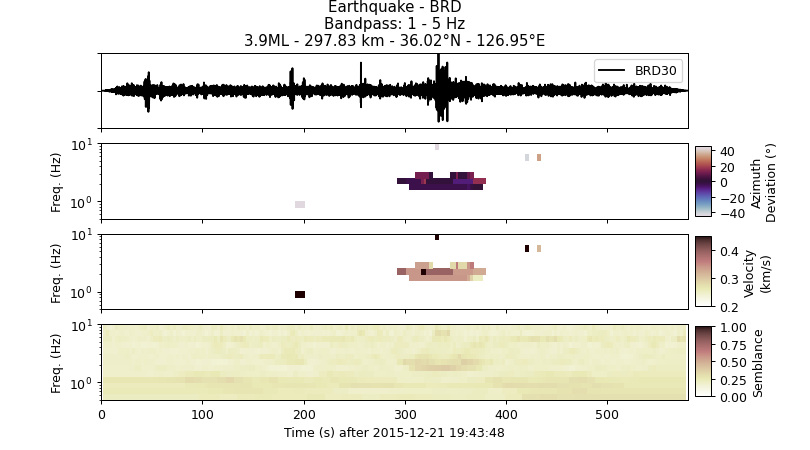

In [18]:
%matplotlib notebook
# Geographic coordinates of arrays
BRD_coords = [37.9709, 124.6519]
CHN_coords = [38.2773, 127.1228]
KSG_coords = [38.5954, 128.3519]
# Define Geod for Great Circle computations
g = Geod(ellps='sphere')
# Constructing frequency bands
f_bands = KGN.make_custom_fbands(f_min=0.5, f_max=10+1, type='third_octave')
f_bands['fmax'][-1:] = np.floor(f_bands['fmax'][-1:]) # round
#-----------------------------------------------------------------------------------------------------------------------#
# Event metadata
event_type='Earthquake'; array='BRD'
lat = '36.02'; lon = '126.95'
mag = '3.9'; dist = '297.83'
date_time = '2015/355 19:31:24'
#-----------------------------------------------------------------------------------------------------------------------#
# Calculate GT back azimuth
if array == 'BRD':
    _, GT_baz, _ = g.inv(lon, lat, BRD_coords[1], BRD_coords[0])
if array == 'CHN':
    _, GT_baz, _ = g.inv(lon, lat, CHN_coords[1], CHN_coords[0])
if array == 'KSG':
    _, GT_baz, _ = g.inv(lon, lat, KSG_coords[1], KSG_coords[0])
#-----------------------------------------------------------------------------------------------------------------------#
# Loading waveforms and array processing results
directory_wavf = '/Volumes/Extreme SSD/Korea_Events/'+event_type+'s/Infrasound/Waveforms/'+array
directory_cardinal = '/Volumes/Extreme SSD/Korea_Events/'+event_type+'s/Infrasound/Cardinal/'+array
try:
    st = read(directory_wavf+'/'+date_time.replace('/','_').replace(' ','_').replace(':','-')+'.mseed')
    B = np.load(directory_cardinal+'/B_'+date_time.replace('/','_').replace(' ','_').replace(':','-')+'.npy')[0]
    V = np.load(directory_cardinal+'/V_'+date_time.replace('/','_').replace(' ','_').replace(':','-')+'.npy')[0]
    S = np.load(directory_cardinal+'/S_'+date_time.replace('/','_').replace(' ','_').replace(':','-')+'.npy')[0]
    T = np.load(directory_cardinal+'/T_'+date_time.replace('/','_').replace(' ','_').replace(':','-')+'.npy')[0]; T = T.reshape(1,len(T))
except:
    directory_wavf = '/Volumes/Extreme SSD/Korea_Events/'+event_type+'s/Infrasound/Han_2023/Waveforms/'+array
    directory_cardinal = '/Volumes/Extreme SSD/Korea_Events/'+event_type+'s/Infrasound/Han_2023/Cardinal/'+array
    st = read(directory_wavf+'/'+date_time.replace('/','_').replace(' ','_').replace(':','-')+'.mseed')
    B = np.load(directory_cardinal+'/B_'+date_time.replace('/','_').replace(' ','_').replace(':','-')+'.npy')[0]
    V = np.load(directory_cardinal+'/V_'+date_time.replace('/','_').replace(' ','_').replace(':','-')+'.npy')[0]
    S = np.load(directory_cardinal+'/S_'+date_time.replace('/','_').replace(' ','_').replace(':','-')+'.npy')[0]
    T = np.load(directory_cardinal+'/T_'+date_time.replace('/','_').replace(' ','_').replace(':','-')+'.npy')[0]; T = T.reshape(1,len(T))
#-----------------------------------------------------------------------------------------------------------------------#
# Bilinear resize
B = KGN.bilinear_resize(B, new_h=B.shape[0], new_w=200)
V = KGN.bilinear_resize(V, new_h=V.shape[0], new_w=200)
S = KGN.bilinear_resize(S, new_h=S.shape[0], new_w=200)
T = KGN.bilinear_resize(T, new_h=T.shape[0], new_w=200)[0,:]
#-----------------------------------------------------------------------------------------------------------------------#
# Plotting
KGN.plot_infrasound_modality(st, st[6].stats.station, f_bands, T, B, V, S, log_freq=True, bandpass=[1,5], plot_real_amplitude=False, GT_baz=GT_baz, clim_baz=[-45,45], clim_vtr=[0.2,0.45], semblance_threshold=0.25,
                             title=event_type+' - '+array+'\nBandpass: 1 - 5 Hz\n'+str(mag)+'ML - '+str(dist)+' km - '+str(lat)+'\N{DEGREE SIGN}N - '+str(lon)+'\N{DEGREE SIGN}E',
                            legend_loc='upper right')